# Making Many Filtered Maps

I need to generate many filtered maps at the same time to look at the population of them.

## Boilerplate

In [1]:
import logging
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3.units as u

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    # get_planck_noise_data, 
    # get_planck_hm_data, 
    get_map_dtype
    )
from cmbml.utils.fits_inspection import get_field_unit

from system_config import ASSETS_DIRECTORY, NOISE_DIRECTORY

In [2]:
# Logging was helpful when debugging my handle_data module
logging.basicConfig(
    level=logging.WARNING,  # If DEBUG, there's a bunch of PySM3 and Matplotlib stuff
    format='%(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [3]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"(unit)"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [4]:
CENTER_FREQS = {
    30: 28.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    44: 44.1 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    70: 70.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    100: 100.89 * u.GHz,   # Value from Planck DeltaBandpassTable
    143: 142.876 * u.GHz,  # Value from Planck DeltaBandpassTable
    217: 221.156 * u.GHz,  # Value from Planck DeltaBandpassTable
    353: 357.5 * u.GHz,    # Value from Planck DeltaBandpassTable
    545: 555.2 * u.GHz,    # Value from Planck DeltaBandpassTable
    857: 866.8 * u.GHz,    # Value from Planck DeltaBandpassTable
}

In [5]:
def get_xxcov_field_num(detector, field_str):
    if detector not in [30, 44, 70, 100, 143, 217, 353, 545, 857]:
        raise ValueError(f"Detector {detector} not recognized")
    field_str = field_str.lower()
    lower_field_nums = dict(ii=4, iq=5, iu=6, qq=7, qu=8, uu=9)
    upper_field_nums = dict(ii=2)  # These detectors only have intensity data
    if detector in [545, 857]:
        if field_str not in upper_field_nums.keys():
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = upper_field_nums[field_str]
    else:
        if field_str not in ['ii', 'iq', 'iu', 'qq', 'qu', 'uu']:
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = lower_field_nums[field_str]
    return res

In [6]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [7]:
def get_unit_from_str(unit_str):
    if unit_str in ['uK_CMB']:
        return u.uK_CMB
    elif unit_str in ['Kcmb', 'K_CMB']:
        return u.K_CMB
    elif unit_str in ['MJy/sr']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

def get_sqrt_unit_from_str(unit_str):
    if unit_str in ['Kcmb^2', '(K_CMB)^2', 'K_CMB^2']:
        return u.K_CMB
    elif unit_str in ['uK_CMB^2', '(uK_CMB)^2']:
        return u.uK_CMB
    elif unit_str in ['(MJy/sr)^2', '(Mjy/sr)^2', 'MJy/sr^2']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

In [8]:
def get_scale_map(det, nside_out):
    obs_fn = get_planck_obs_data(detector=det, assets_directory=ASSETS_DIRECTORY)
    use_field = get_xxcov_field_num(det, 'II')
    II_cov_map = hp.read_map(obs_fn, hdu=1, field=use_field)
    II_cov_map_512 = _change_variance_map_resolution(II_cov_map, nside_out)
    scale_map = np.sqrt(II_cov_map_512)

    var_map_unit = get_field_unit(obs_fn, hdu=1, field_idx=use_field)
    var_map_unit = get_sqrt_unit_from_str(var_map_unit)
    scale_map = scale_map * var_map_unit
    scale_map = u.Quantity(scale_map, unit=var_map_unit)

    return scale_map

In [9]:
def make_tgt_noise_params(det, n_sims):
    # use_diff_str = 'diff' if det in [353, 545, 857] else 'no_diff'
    use_diff_str = 'no_diff'
    data = np.load(f"noise_models/noise_model_{det}GHz_{use_diff_str}.npz")

    src_mean_ps     = data['mean_ps']
    src_components  = data['components']
    src_variance    = data['variance']

    src_mean_maps   = data['maps_mean']
    src_sd_maps     = data['maps_sd']
    src_map_unit    = data['maps_unit']

    num_components = len(src_variance)

    std_devs = np.sqrt(src_variance)

    if n_sims == 1:
        reduced_samples = np.random.normal(0, std_devs, (num_components,))
        # Reconstruct power spectra in log10 space
        tgt_log_ps = reduced_samples @ src_components + src_mean_ps
        # Convert out of log10 space
        tgt_cls = 10**tgt_log_ps
    else:
        reduced_samples = np.random.normal(0, std_devs, (n_sims, num_components))
        # Reconstruct power spectra in log10 space
        tgt_log_ps = reduced_samples @ src_components + src_mean_ps
        # Convert out of log10 space
        tgt_cls = 10**tgt_log_ps

    src_map_unit = get_unit_from_str(src_map_unit)

    return tgt_cls, src_mean_maps, src_sd_maps, src_map_unit

In [10]:
def downgrade_map_via_alm(some_map, target_nside):
    source_nside = hp.get_nside(some_map)
    assert target_nside <= source_nside/2, "Target nside must be less than the source nside"
    lmax_source = 3 * source_nside - 1
    alm = hp.map2alm(some_map, lmax=lmax_source)

    lmax_target = int(3 * target_nside - 1)
    alm_filter = np.zeros(lmax_source+1)
    alm_filter[:lmax_target+1] = 1
    alm_filtered = hp.almxfl(alm, alm_filter)
    some_map_filtered = hp.alm2map(alm_filtered, nside=target_nside)
    return some_map_filtered

In [11]:
def get_avg_map(detector, nside_out):
    scale = 1 if detector in [545, 857] else 1e6  # Convert to uK unless units are MJy/sr
    fn = f"noise_avgs/avg_noise_map_{detector}_TQU_100.fits"
    planck_nse_avg = hp.read_map(fn) * scale

    if hp.get_nside(planck_nse_avg) != nside_out:
        planck_nse_avg = downgrade_map_via_alm(planck_nse_avg, nside_out)
    return planck_nse_avg

# Start Here

In [12]:
def make_filter_noise_map(detector, n_sims, seed=42, nside_out=512, return_dict=False):
    if detector in [353, 545, 857]:
        mode='no_diff'
    else:
        mode='diff'
    # Set parameters
    np.random.seed(seed)
    lmax = 3*nside_out-1
    rng = np.random.default_rng(seed)

    # Get target noise parameters
    tgt_cl, tgt_dist_mean, tgt_dist_sd, tgt_unit = make_tgt_noise_params(detector, n_sims=n_sims)

    tgt_cl = tgt_cl * tgt_unit**2
    min_dist_t = (tgt_dist_mean - 3*tgt_dist_sd)              * tgt_unit  # outside this range, adjust monopole
    max_dist_t = (tgt_dist_mean + 3*tgt_dist_sd)              * tgt_unit

    # Get target means and sign
    tgt_means = np.random.normal(tgt_dist_mean, tgt_dist_sd, size=(n_sims, tgt_dist_mean.size)) * tgt_unit
    tgt_signs = np.sign(tgt_means)

    # Make aniso white noise maps
    scale_map = get_scale_map(detector, nside_out)
    wht_nse_map = rng.normal(size=(n_sims, scale_map.size)) * scale_map

    # Check for unit consistency (both target and white should be in source units, either K_CMB or MJy/sr)
    assert tgt_unit == wht_nse_map.unit, f"Stopping. tgt_unit is {tgt_unit}, wht_nse_map.unit is {wht_nse_map.unit}"

    # Reverse sign of aniso white noise map if needed
    wht_means  = wht_nse_map.mean(axis=1)
    wht_signs  = np.sign(wht_means).reshape(tgt_signs.shape)
    flip_signs = wht_signs * tgt_signs

    wht_nse_map = wht_nse_map * flip_signs

    if return_dict:
        res = dict(
            tgt_cls=tgt_cl,
            tgt_means=tgt_means,
            wht_maps=wht_nse_map,
            wht_cls=[],
            wht_means=wht_nse_map.mean(axis=1),
            filters=[],
            filtered_maps_nonstat=[],
            filtered_maps=[]
        )
    else:
        res = []

    avg_map = get_avg_map(detector, nside_out) * tgt_unit

    # Make map filter, non-vectorized because healpy (improvements welcomed!)
    for i in range(n_sims):
        wht_nse_alms  = hp.map2alm(wht_nse_map[i], lmax=lmax)
        wht_nse_cl    = hp.alm2cl(wht_nse_alms) * wht_nse_map.unit**2
        map_filter    = np.sqrt(tgt_cl[i][:lmax+1] / wht_nse_cl)

        # Filter map
        filtered_alms = hp.almxfl(wht_nse_alms, map_filter)
        filtered_map_nonstat  = hp.alm2map(filtered_alms, nside=nside_out) * tgt_unit

        if mode == 'diff':
            filtered_map = filtered_map_nonstat + avg_map
        else:
            filtered_map = filtered_map_nonstat
            print("You really ought to correct the monopole again here, Jim.")

        if return_dict:
            res['wht_cls'].append(wht_nse_cl)
            res['filters'].append(map_filter)
            res['filtered_maps_nonstat'].append(filtered_map_nonstat)
            res['filtered_maps'].append(filtered_map)
        else:
            res.append(filtered_map)

    return res

In [13]:
n_sims = 2

You really ought to correct the monopole again here, Jim.
You really ought to correct the monopole again here, Jim.


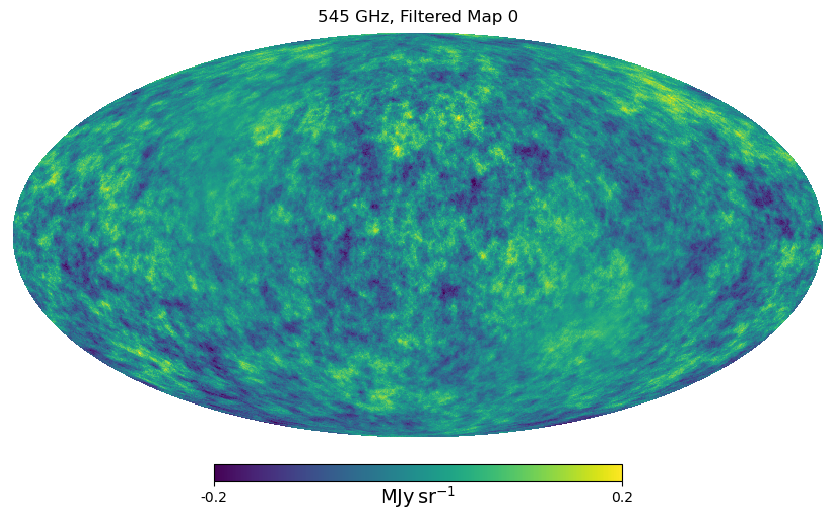

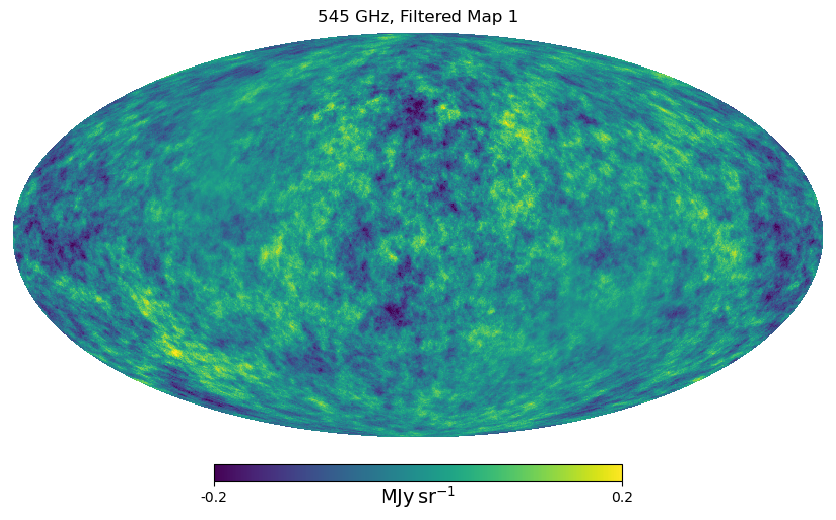

In [14]:
det = 545
nside_out = 512
res = make_filter_noise_map(det, n_sims=n_sims, seed=42, nside_out=nside_out, return_dict=True)
filtered_maps_512  = res['filtered_maps'].copy()
filtered_maps_nonstat_512  = res['filtered_maps_nonstat'].copy()
for i in range(n_sims):
    # hp.mollview(filtered_maps_512[i], 
    #             title=f"{det} GHz, Filtered Map {i}", min=-0.2, max=0.2, 
    #             unit=filtered_maps_512[i].unit.to_string('latex_inline'))
    hp.mollview(filtered_maps_nonstat_512[i], 
                title=f"{det} GHz, Filtered Map {i}", min=-0.2, max=0.2, 
                unit=filtered_maps_nonstat_512[i].unit.to_string('latex_inline'))


You really ought to correct the monopole again here, Jim.
You really ought to correct the monopole again here, Jim.


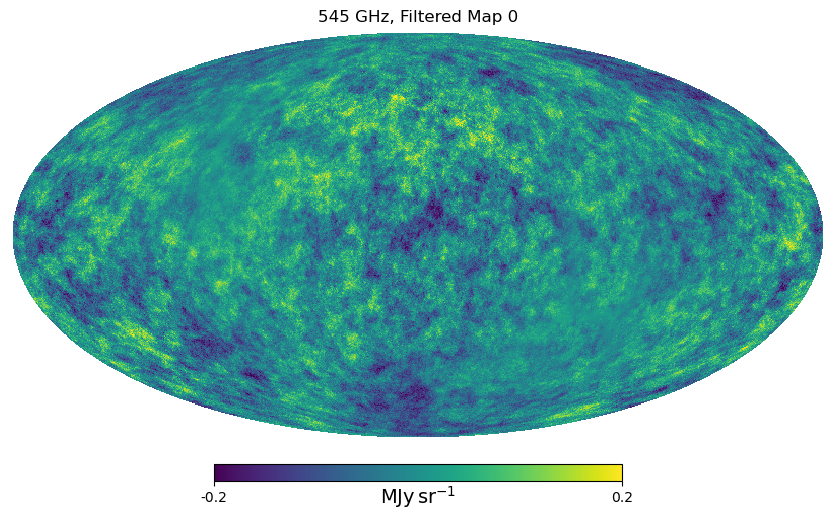

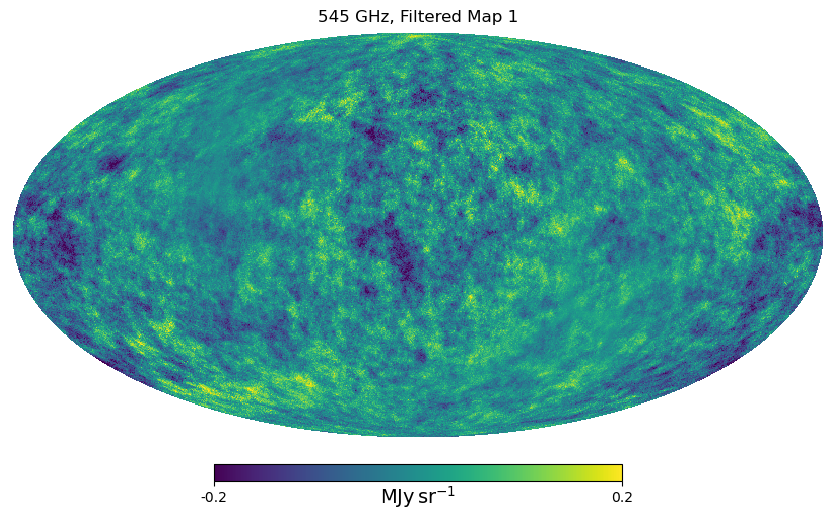

In [15]:
det = 545
nside_out = 2048
res = make_filter_noise_map(det, n_sims=n_sims, seed=42, nside_out=nside_out, return_dict=True)
filtered_maps_2048  = res['filtered_maps'].copy()
filtered_maps_nonstat_2048  = res['filtered_maps_nonstat'].copy()
for i in range(n_sims):
    # hp.mollview(filtered_maps_2048[i], 
    #             title=f"{det} GHz, Filtered Map {i}", min=-0.2, max=0.2, 
    #             unit=filtered_maps_2048[i].unit.to_string('latex_inline'))
    hp.mollview(filtered_maps_nonstat_2048[i], 
                title=f"{det} GHz, Filtered Map {i}", min=-0.2, max=0.2, 
                unit=filtered_maps_nonstat_2048[i].unit.to_string('latex_inline'))

In [16]:
filtered_cls_512 = [
    hp.anafast(filtered_maps_512[i], lmax=3*512-1) for i in range(n_sims)
]
filtered_cls_2048 = [
    hp.anafast(filtered_maps_2048[i], lmax=3*2048-1) for i in range(n_sims)
]

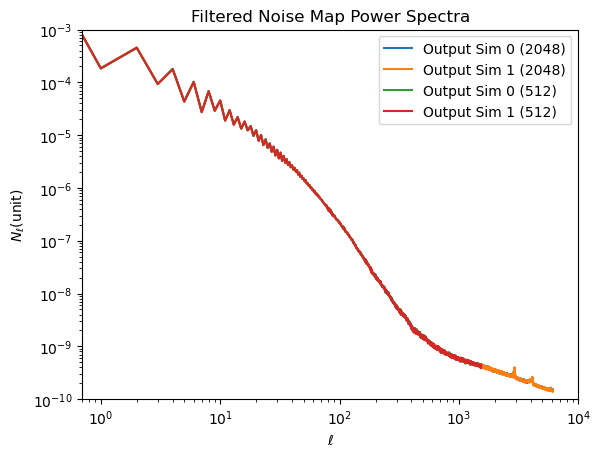

In [17]:
plot_many_ps([
              *filtered_cls_2048,
              *filtered_cls_512
              ],
             title="Filtered Noise Map Power Spectra",
             labels=[
                 *[f"Output Sim {i} (2048)" for i in range(n_sims)],
                 *[f"Output Sim {i} (512)" for i in range(n_sims)],
             ],
             y_low=1e-10, y_high=1e-3,
             focus_first=False)

In [18]:
filtered_cls_512_nonstat = [
    hp.anafast(filtered_maps_nonstat_512[i], lmax=3*512-1) for i in range(n_sims)
]
filtered_cls_2048_nonstat = [
    hp.anafast(filtered_maps_nonstat_2048[i], lmax=3*2048-1) for i in range(n_sims)
]

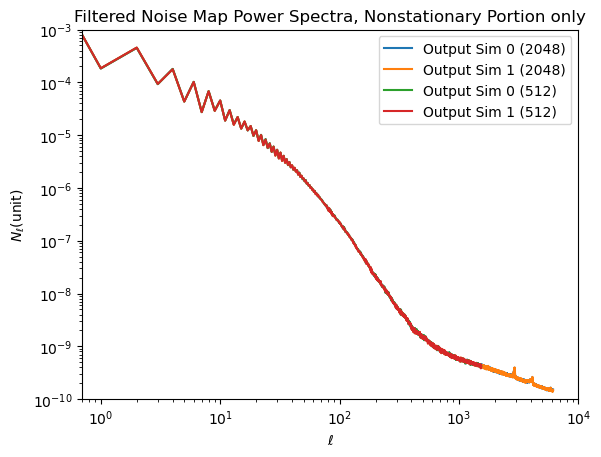

In [19]:
plot_many_ps([
              *filtered_cls_2048_nonstat,
              *filtered_cls_512_nonstat
              ],
             title="Filtered Noise Map Power Spectra, Nonstationary Portion only",
             labels=[
                 *[f"Output Sim {i} (2048)" for i in range(n_sims)],
                 *[f"Output Sim {i} (512)" for i in range(n_sims)],
             ],
             y_low=1e-10, y_high=1e-3,
             focus_first=False)

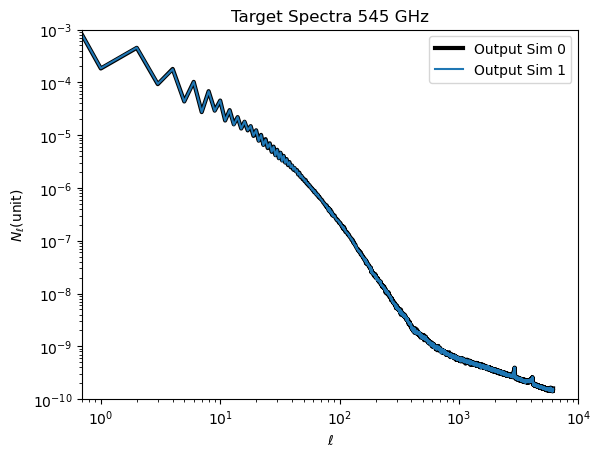

In [20]:
target_cls = res['tgt_cls'].copy()
plot_many_ps(target_cls,
             title=f"Target Spectra {det} GHz",
             labels=[f"Output Sim {i}" for i in range(n_sims)],
             y_low=1e-10, y_high=1e-3,
             focus_first=True)